Michael Toolin<br>
Natural Language Processing<br>
DS 7337-403 <br>
Homework 7

In [1]:

""""
Created on Thu Mar 21 20:34:52 2019

@author: mtool
"""
import sys; print ("Python", sys.version)
from nltk.corpus import stopwords
import nltk
from nltk import Tree
import string
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup 

import random
from matplotlib.font_manager import FontProperties
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
import re
import numpy as np

from scipy.cluster.hierarchy import ward, dendrogram, linkage

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Python 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mtool\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mtool\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mtool\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Movie genre selection and high level algorithm approach
I chose to examine reviews for the top 240 horror movies listed on the IMDB site. The following steps were used to scrape each page and find the permalink and eventually the review text for each movie. This is the same algorithm used in Homework 5.<br>
 * I used the URL of this website to scrape the URL's for each individual movie.  These URLs are savedin a dictionary containing **{title:movieURL}**<br><br>
 * Within each movies page, I noticed the difference between the movies's main page and the user review page was the attribute on the end of the URL. All movie review pages had the same attribute. I created a new dictionary saving the user review URL **{title:reviewURL}**.<br><br>
 * Within each user review page a pattern was found identifying the permalink for each user review.<br> The review was downloaded and saved in it's own dictionary **{title:reviewText}**.<br><br>
 * Gather all the reviews and run the clustering algorithm on them. I run k-means clustering, checking to see what number of clusters from 2 to 10 give the best results.
 * Finally I reduce the dimenionality using PCA and plot the resulting clusters
 
 #### Get the URL for all 240 movies and save in dictionary titled reviewDict{}


In [2]:
#%%
#
# Top 240 horror movies @ https://www.imdb.com/list/ls059633855/
#
debug = False
pages = ['1', '2', '3']
reviewAttrb = 'reviews?ref_=tt_ql_3'
movieAttrb = '?ref_=ttls_li_tt'
reviewDict = {}

#
# Get all URL's from page of 240 horror movies listing.
# Each movie has multiple pages, but we want the one that has the
# attribute ?ref_=ttls_li_tt.  Once we find these, get the title of the
# movie and then update the URL to point to the review page by replacing
# the attribute with reviews?ref_=tt_ql_3
# Create a dictionary of the movie titles and the URLs to user review pages
# Note this URL points to the page with ALL the reviews for the movie
#
# I noticed the page with user reviews for each movie uses the same URL
# but just passes a different attribute after the movie number. I don't have
# to go to each movie page to find the review page, just subst the attribute
# at the end to get to the user review pages
#
for pgNum in pages:
    urlStr='https://www.imdb.com/list/ls059633855/?sort=list_order,asc&st_dt=&mode=detail&page='+pgNum
    page = requests.get(urlStr)
    soup = BeautifulSoup(page.text,'html.parser')
    print("Getting movie page URL's in page {}".format(pgNum))
    for a in soup.find_all('a', href=re.compile('/?ref_=ttls_li_tt')):
        if debug:
            print ("Found the URL:", a['href'],'for the movie', a.contents[0])
        revURL = a['href'].replace(movieAttrb, reviewAttrb)
        revURL = 'https://www.imdb.com'+ revURL
        title = str(a.contents[0])
        reviewDict [title] = revURL
print('\nTotal of URLs found = ', len(reviewDict.keys()))

Getting movie page URL's in page 1
Getting movie page URL's in page 2
Getting movie page URL's in page 3

Total of URLs found =  241


#### Find the PermaLink URL for the first review for each movie
Store the PermaLink URL in the dictionary named permaDict{title:permaURL}

In [3]:
#%%
#
# Find first permaLink and create a dictionary 
# {Movie title:permaLink} This page has movie rankings by user, etc...
#
permaDict ={}
print ("Getting PermaLinks...\n")
for k in reviewDict:
    reviewURL = reviewDict.get(k)
    title = str(k)                             # Save title for key in new Dict
    reviewPage = requests.get(reviewURL)
    reviewSoup = BeautifulSoup(reviewPage.text, 'html.parser')
    permaTag = reviewSoup.find('a', href=re.compile('/review/rw')) 
    if debug:
        print('PermaLink review URL:', permaTag['href'],'for movie',k)  
    permaURL = 'https://www.imdb.com'+ permaTag['href']
    permaDict [title] = permaURL      

Getting PermaLinks...



#### Retrieve the body of each review and store in a dictionary textDict{title:reviewText}

In [6]:
#%%
#
# Retrieve the body of each each review and store in a dictionary
# {Title: Review Text}
#
textDict = {}
print('Getting review text... \n')
for k1 in permaDict:
    rawReviewText =''                           # Clear the buffer
    permaURL = permaDict.get(k1)
    title = str (k1)                            # Keep track of the movie title
    permaPage = requests.get(permaURL)
    permaSoup = BeautifulSoup(permaPage.text, 'html.parser')
    permaTag = permaSoup.find('div', {'class':'text show-more__control'})
    [p.replace_with(' ') for p in permaTag.findAll('br')]
    if debug:
        print(permaURL)
        print('Movie',k1, 'has text',permaTag.contents[0])
    for t in permaTag:
        rawReviewText = rawReviewText+ str(t)
    textDict[title] = rawReviewText

Getting review text... 



#### Create Tfidf vectors and features
Save the list of Movie titles in a list for easier access later

In [7]:
#
# Create list of individual reviews
# Then create tfidf vectors and get feature names
#
listOfReviews = []
listOfMovies = []
for k2 in textDict:
    listOfReviews.append(textDict.get(k2))
    listOfMovies.append(k2)
stopwordList = nltk.corpus.stopwords.words('english')
#tokenizer = RegexpTokenizer(r'\w+')
#TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, stop_words=stopwordList)
TfidfVec = TfidfVectorizer(stop_words=stopwordList)
tfidfReviewMatrix = TfidfVec.fit_transform(listOfReviews)
tfidfReviewFeatureNames = TfidfVec.get_feature_names()

#### Run the K-means clustering algorithm on the list of reviews.
I keep track of which number of clusters did the best job by checking the silhoutte score
and keeping track of that model.\n Looking at the silhoutte score reveals k = 3 clusters performed the best clustering on the data. However there was not any very good clustering of the reviews with any number of clusters with all silhoutte scores being below .005. The k=3 cluster barely performed better the k=2 or k=5. This may be due to the fact that each review is written by a different author so we are not finding alot commonality in the text.  What commonality we do find is most likely due to the all the reviews being written about the same genre of movies.

In [8]:
numOfClustersToTest = [2, 3, 4, 5, 6, 7, 8, 9 ,10]
bestCluster = 0                                 # Initalize this to zero
bestSilhoutteScore = 0
clusterListByMovie = []                                 # Use list of tuples to keep order
#
# Test which clustering size gives the densest clusters by checking 
# silhoutte scores
# Save the best clustering to analyze 
#
for nClusters in numOfClustersToTest:
    km = KMeans(n_clusters=nClusters, random_state=10,tol=.0001, max_iter=1000)
    clusterLabels = km.fit_predict(tfidfReviewMatrix)   
    silhouette_avg = metrics.silhouette_score(tfidfReviewMatrix, clusterLabels)
    sample_silhouette_values = metrics.silhouette_samples(tfidfReviewMatrix, 
                                                          clusterLabels)
    if silhouette_avg > bestSilhoutteScore:
        bestSilhoutteScore =  silhouette_avg
        bestCluster = nClusters
        bestKM = km
        clusters = km.labels_

#
# Graph and Print out the results
#
    
    print ('For {} clusters'.format(nClusters))
    print (Counter(km.labels_))
    print ('Silhoutte score:{:.6f}\n'.format(silhouette_avg))
    
print ('-'*20)
print('The best clustering was seen with {} clusters'.format(bestCluster))
#
# Build the cluster list of tuples such that (Movie,ClusterNumber)
# Use lists here rather than dictionaires because the order a dictionary
# is created is not guaranteed. 
#        
for i, k in enumerate (listOfMovies): clusterListByMovie.append((k,clusters[i]))
       

For 2 clusters
Counter({0: 161, 1: 80})
Silhoutte score:0.002954

For 3 clusters
Counter({1: 138, 2: 99, 0: 4})
Silhoutte score:0.003907

For 4 clusters
Counter({2: 109, 1: 62, 3: 55, 0: 15})
Silhoutte score:0.001818

For 5 clusters
Counter({1: 103, 4: 58, 2: 52, 3: 24, 0: 4})
Silhoutte score:0.002125

For 6 clusters
Counter({1: 84, 4: 56, 2: 46, 5: 34, 3: 17, 0: 4})
Silhoutte score:0.001283

For 7 clusters
Counter({3: 74, 1: 60, 5: 52, 2: 34, 0: 10, 4: 7, 6: 4})
Silhoutte score:-0.001449

For 8 clusters
Counter({1: 63, 7: 55, 5: 46, 3: 22, 4: 17, 6: 15, 2: 15, 0: 8})
Silhoutte score:0.000558

For 9 clusters
Counter({6: 71, 1: 38, 3: 35, 2: 28, 8: 25, 7: 19, 5: 13, 4: 8, 0: 4})
Silhoutte score:0.001221

For 10 clusters
Counter({2: 41, 9: 41, 8: 36, 5: 32, 1: 32, 6: 23, 7: 19, 3: 8, 4: 5, 0: 4})
Silhoutte score:0.000439

--------------------
The best clustering was seen with 3 clusters


#### Question 2 - Characterize what each cluster is centered on semantically
It seems clear the **Cluster 0** is centered on Named Entities. This cluster only contains 4 books and the names Sarah, Juno and Musouka are charachters in the books this cluster. Also, the books *The Descent*, and *The Descent: Part 2* are most likely part of a series and is very likely some if not all of these names are in these books. This cluster also has other nouns which name people like *scientist* and *sheriff* so it makes sense that they are all put together.\n
**Cluster 1** and **Cluster 2** share some of the same features. Words like *film*, *movie*, *horror* and *story* are each features of both clusters. This makes it seem as if these two clusters have more in common than they do with **Cluster 0**.  The two features that distinguish **Cluster 1** from **Cluster 2** are *good* and *watch*. These features appear in **Cluster 2** and could mean these movies were more favorably rated then the movies in **Cluster 1**. A good next step would be tolook at the titles of these movies and compare user ratings to see if each cluster has similar user rating scores.

In [9]:
#
# Get cluster information into form for displaying
#
clusterInfo = {}
centers = bestKM.cluster_centers_.argsort()[:,::-1]
for clusterNum in range(bestCluster):
    movies = []
    clusterInfo[clusterNum] = {}
    clusterInfo[clusterNum]['clusterNum'] = clusterNum
    keyFeatures = [tfidfReviewFeatureNames[i] for i in centers[clusterNum,:10]]
    clusterInfo[clusterNum]['keyFeatures'] = keyFeatures
    for x, y in enumerate(clusterListByMovie):
        if clusterListByMovie[x][1] == clusterNum: movies.append(y[0])

    clusterInfo[clusterNum]['movies'] = movies
#
# Print out thge cluster information for the number of clusters with highest score.
#
for cluster_num, cluster_details in clusterInfo.items():
    print ('Cluster {} details:'.format(cluster_num))
    print ('-'*20)
    print ('Key features:', cluster_details['keyFeatures'])
    print ('Movies in this cluster:')
    print (', '.join(cluster_details['movies']))
    print ('='*40)  

Cluster 0 details:
--------------------
Key features: ['sarah', 'juno', 'masuoka', 'cave', 'decisions', 'polley', 'scientists', 'monsters', 'subconscious', 'sheriff']
Movies in this cluster:
The Descent, Marebito, The Descent: Part 2, Splice
Cluster 1 details:
--------------------
Key features: ['film', 'horror', 'one', 'films', 'movie', 'like', 'story', 'see', 'first', 'well']
Movies in this cluster:
The Wailing, 28 Days Later..., Let the Right One In, The Conjuring, A Quiet Place, [Rec], The VVitch: A New-England Folktale, The Mist, Battle Royale, Saam gaang yi, Saw, A Tale of Two Sisters, Split, The Devil's Rejects, House of 1000 Corpses, Shutter, It, Southbound, 1408, Under the Shadow, Kairo, The Autopsy of Jane Doe, Baskin, The Devil's Backbone, Mientras duermes, Ju-on: The Grudge, 28 Weeks Later, Inside, Ha phraeng, The House of the Devil, Taxidermia, Gozu, High Tension, The Cabin in the Woods, Gin gwai, Dawn of the Dead, Ginger Snaps, Ginger Snaps 2: Unleashed, Otesánek, Brother

#### Reduce the dimensionality of the feature matrix
Here I reduce the dimensionality of the feature matrix to put it into a form that can be better visualized. Note that using 2 principal components each principal component explains nearly the same amount of variance. This is further evidence the our data is randomly scattered and not well clustered.

In [10]:
#
# Change tfidfReviewMatrix Sparse Matrix into a numpy matrix
# Reduce dimensionalty by create PCA matrix
#
tfpd = pd.DataFrame(tfidfReviewMatrix.todense())   
pca = PCA(n_components=2).fit(tfpd)  
tfpdPcaTransform = pca.fit_transform(tfpd)  
       
print ('\nThe vector for each Principle Component')
print ('---------------------------------------')
print('The vector for the First Principle Component is:{} \
      \nThe vector for the Second Principle Component is {}'.format(
      pca.components_[0],pca.components_[1]))

print ('\nThe variance explained by each Principle Component')
print ('-----------------------------------------------------')
print('The variance for the First Principle Component is:{} \
      \nThe variance for the Second Principle Component is {}'.format(
      pca.explained_variance_[0],pca.explained_variance_[1]))


The vector for each Principle Component
---------------------------------------
The vector for the First Principle Component is:[-0.00214997 -0.00147678  0.03935009 ...  0.00015687  0.00205866
 -0.0001178 ]       
The vector for the Second Principle Component is [ 0.00127031 -0.0072254  -0.0765017  ... -0.00018229 -0.00089746
  0.00134223]

The variance explained by each Principle Component
-----------------------------------------------------
The variance for the First Principle Component is:0.011207117003984864       
The variance for the Second Principle Component is 0.008377777580210459


#### Fit the K-means clustering model on the PCA matrix

In [11]:
kmeans = KMeans(n_clusters=bestCluster)
clusterLabels = kmeans.fit_predict(tfpdPcaTransform)
centroid = kmeans.cluster_centers_
labels = kmeans.labels_
print ('\nThe centroid coordinates for each group')
print ('-----------------------------------------')
print (centroid)


The centroid coordinates for each group
-----------------------------------------
[[ 0.1215753  -0.0160439 ]
 [-0.03916068  0.07891908]
 [-0.08641312 -0.08800009]]


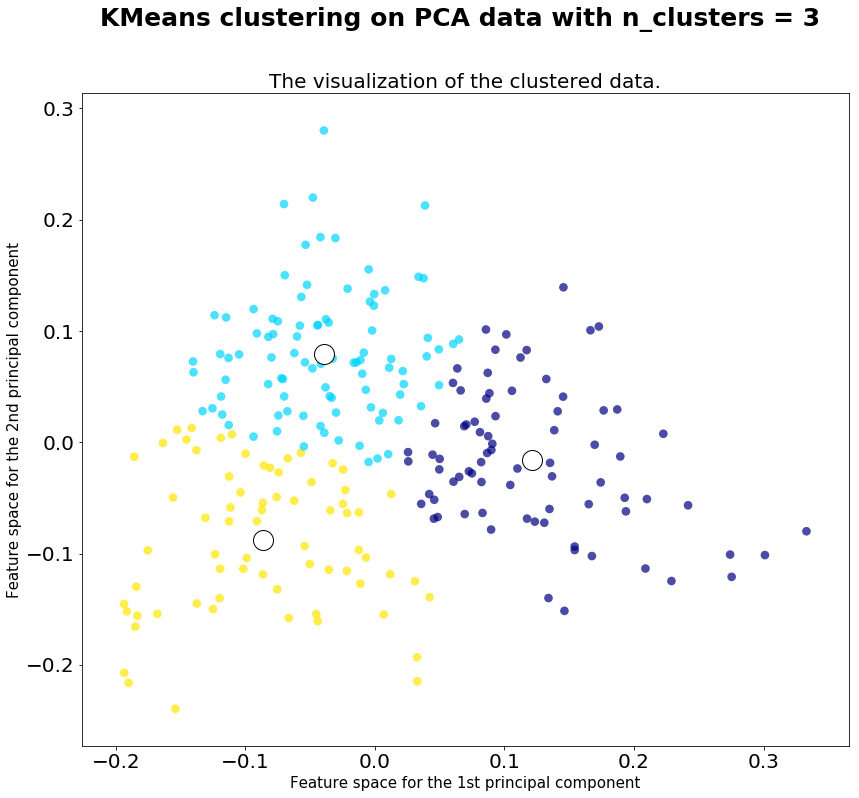

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
colors = cm.jet(clusterLabels.astype(float) / bestCluster)
ax.scatter(tfpdPcaTransform[:, 0], tfpdPcaTransform[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
ax.scatter(centers[:, 0], centers[:, 1],marker='o',
                c="white", alpha=1, s=400, edgecolor='k')

ax.set_title("The visualization of the clustered data.", fontsize=20)
ax.set_xlabel("Feature space for the 1st principal component", fontsize=15)
ax.set_ylabel("Feature space for the 2nd principal component", fontsize=15)

plt.suptitle(("KMeans clustering on PCA data "
              "with n_clusters = %d" % bestCluster),
            fontsize=25, fontweight='bold')
        
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

plt.show()

#### Examine a clustering with k = 5
As expected by the very similar silhoutte scores, we can find very good clustering with k = 5. We don't have any outliers in the clusters and k=5 could be viewed as a valid clustering model also. If we look at the features for each cluster we start seeing more similarity among clusters meaning there is not much difference between these clusters so seperating them may not be a good idea.  Since we have very similar metrics and the features start looking very much the same, it is probably a good idea to keep the number of clusters down so I will use the k=3 clustering model.


The centroid coordinates for each group
-----------------------------------------
[[-0.0834169  -0.00558202]
 [ 0.06998653  0.01972329]
 [-0.04188236  0.11478016]
 [ 0.185108   -0.06505821]
 [-0.08570377 -0.14169204]]


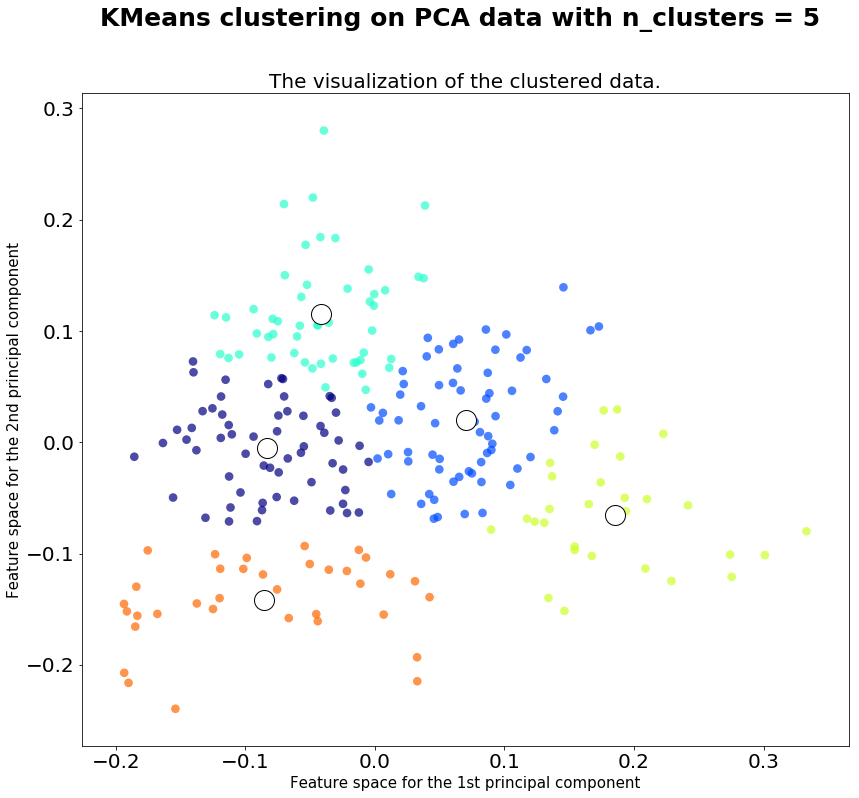

In [13]:
kmeans = KMeans(n_clusters=5)
clusterLabels = kmeans.fit_predict(tfpdPcaTransform)
centroid = kmeans.cluster_centers_
labels = kmeans.labels_
print ('\nThe centroid coordinates for each group')
print ('-----------------------------------------')
print (centroid)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
colors = cm.jet(clusterLabels.astype(float) / 5)
ax.scatter(tfpdPcaTransform[:, 0], tfpdPcaTransform[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
ax.scatter(centers[:, 0], centers[:, 1],marker='o',
                c="white", alpha=1, s=400, edgecolor='k')

ax.set_title("The visualization of the clustered data.", fontsize=20)
ax.set_xlabel("Feature space for the 1st principal component", fontsize=15)
ax.set_ylabel("Feature space for the 2nd principal component", fontsize=15)

plt.suptitle(("KMeans clustering on PCA data "
              "with n_clusters = %d" % 5),
            fontsize=25, fontweight='bold')
        
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

plt.show()

In [14]:
#
# Get cluster information into form for displaying
#
k=5
km = KMeans(n_clusters=k, random_state=10,tol=.0001, max_iter=1000)
clusterLabels = km.fit_predict(tfidfReviewMatrix) 
clusterListByMovie = []
for i, k in enumerate (listOfMovies): clusterListByMovie.append((k,clusters[i]))
clusterInfo = {}
centers = km.cluster_centers_.argsort()[:,::-1]
for clusterNum in range(5):
    movies = []
    clusterInfo[clusterNum] = {}
    clusterInfo[clusterNum]['clusterNum'] = clusterNum
    keyFeatures = [tfidfReviewFeatureNames[i] for i in centers[clusterNum,:10]]
    clusterInfo[clusterNum]['keyFeatures'] = keyFeatures
    for x, y in enumerate(clusterListByMovie):
        if clusterListByMovie[x][1] == clusterNum: movies.append(y[0])

    clusterInfo[clusterNum]['movies'] = movies
#
# Print out thge cluster information for the number of clusters with highest score.
#
for cluster_num, cluster_details in clusterInfo.items():
    print ('Cluster {} details:'.format(cluster_num))
    print ('-'*20)
    print ('Key features:', cluster_details['keyFeatures'])
    print ('='*40)  

Cluster 0 details:
--------------------
Key features: ['sarah', 'juno', 'masuoka', 'cave', 'decisions', 'polley', 'scientists', 'monsters', 'subconscious', 'sheriff']
Cluster 1 details:
--------------------
Key features: ['film', 'horror', 'films', 'one', 'movie', 'like', 'see', 'story', 'first', 'characters']
Cluster 2 details:
--------------------
Key features: ['movie', 'film', 'horror', 'story', 'people', 'movies', 'one', 'watch', 'well', 'like']
Cluster 3 details:
--------------------
Key features: ['film', 'saw', 'one', 'sequel', 'werewolf', 'horror', 'story', 'first', 'good', 'ending']
Cluster 4 details:
--------------------
Key features: ['movie', 'horror', 'movies', 'like', 'one', 'good', 'really', 'well', 'watch', 'film']
